# simulating a migrating population of bacteria 

In [1]:
import os

import itertools

from Bio import SeqIO, AlignIO

import gzip
import csv

import subprocess, gzip, tempfile
import shutil

from concurrent.futures import ProcessPoolExecutor, as_completed
import warnings

In [2]:
import tsinfer
import tskit
import msprime
import tsdate

import numpy as np
import pandas as pd

import datetime as dt
import time

import matplotlib.pyplot as plt
%matplotlib inline 

# from sklearn.linear_model import LinearRegression
from itertools import combinations

# [!Note](https://tskit.dev/msprime/docs/latest/demography.html#model)

Migration is described from the perspective of the coalescent, so that when describing migrations in msprime, the following reversed terminology holds:

destination (or dest):
The population containing the immediate ancestors of the migrant(s). Forwards in time, this is where migrants come from. In reverse time, a lineage that is traced backwards in time (i.e. from the current day into the past) will appear to jump into this ancestral destination at the precise time of the migration event.

source:
The population containing the immediate descendants of the migrants. Forwards in time, this is where migrants end up. In reverse time, a lineage traced backwards from the current day will appear to jump from this population into the ancestral (“destination”) population.

In [3]:
# evo model 
seed = 15
pm_ratio = 0.5
mu = 1e-8
rr = pm_ratio * mu 
#rr = 1e-8
length = 1e5

# # demographic model 
# num_populations = 3
num_sinks = 2
# sizes = [3e3] + [1e3] * num_sinks # constant Ne = [3000.0, 500.0, 500.0]
# bg = 1e-6 #background migration rate [everywhere to everywhere] 
# demography = msprime.Demography.island_model(initial_size=sizes, migration_rate=bg)

# src_sink = 6e-4 # source to sink mig rate
# sink_src = 1e-4 # sink to source mig rate
# sink_sink = 2e-4 # sink to sink mig rate

# # source <-> sink, assymetric
# for sink_id in range(1, num_sinks + 1):
#     demography.set_migration_rate(source=0,       dest=sink_id, rate=sink_src)  # sink -> source (backwards in time)
#     demography.set_migration_rate(source=sink_id, dest=0,       rate=src_sink)  # source -> sink (backwards in time)

# # sink <-> sink, symmetric 
sink_ids = list(range(1, num_sinks + 1))
# demography.set_symmetric_migration_rate(populations=sink_ids, rate=sink_sink)

In [4]:
# # random sampling for sample size 

# def random_size(min, max, num_populations): 
#     return None

# migration_rates = [bg, 1e-4, 6e-4, 2e-4] # sink-source, source-sink, sink-sink 

## (1) source-sink island model (contemporaneous, recombinant)

In [5]:
def sim_ss(length, rr, mu, seed): #num_sinks, num_populations, sample_sizes, migration_rates, effective_Nes, ): 
    
    num_populations = 3
    num_sinks = 2
    sizes = [3e3] + [1e3] * num_sinks # constant Ne = [3000.0, 500.0, 500.0]
    bg = 1e-6 #background migration rate [everywhere to everywhere] 
    demography = msprime.Demography.island_model(initial_size=sizes, migration_rate=bg)

    # later: define these outside the function
    src_sink = 6e-4 # source to sink mig rate
    sink_src = 1e-4 # sink to source mig rate
    sink_sink = 2e-4 # sink to sink mig rate

    # source <-> sink, assymetric
    for sink_id in range(1, num_sinks + 1):
        demography.set_migration_rate(source=0,       dest=sink_id, rate=sink_src)  # sink -> source (backwards in time)
        demography.set_migration_rate(source=sink_id, dest=0,       rate=src_sink)  # source -> sink (backwards in time)

    # sink <-> sink, symmetric 
    sink_ids = list(range(1, num_sinks + 1))
    demography.set_symmetric_migration_rate(populations=sink_ids, rate=sink_sink)

    # simulate ancestry 
    ts = msprime.sim_ancestry(
        samples=[msprime.SampleSet(10, population=p) for p in range(0,num_populations)], # 10 samples per/populations
        demography=demography,
        sequence_length=length,
        recombination_rate=rr,
        random_seed=seed,
        record_migrations = True,
        ploidy = 1
    )
    
    ts = msprime.sim_mutations(ts, rate=mu, random_seed=seed)
    samples = list(ts.samples())

    # get ancestral states
    ancestral_states = []
    
    for site in ts.sites():
        if site.ancestral_state is None:
            ancestral_states.append("N")
            #print("N")
        else:
            ancestral_states.append(str(site.ancestral_state))
            #print(site.ancestral_state)
    
    ancestral_states = np.array(ancestral_states)

    # parameters for inference
    sample_nodes = np.array(list(ts.samples()), dtype=int)
    individuals_time = ts.tables.nodes.time[sample_nodes]

    return ts, samples, ancestral_states, individuals_time 

## (2) symmetric migration island model (contemporaneous, recombinant)

In [6]:
def sim_eq(length, rr, mu, seed): #num_populations, sample_sizes, migration_rate, effective_Ne, ): 
    
    num_populations = 3
    sizes = [3e3] * num_populations # constant Ne = [3000.0]
    bg = 1e-6 #background migration rate [everywhere to everywhere] 
    demography = msprime.Demography.island_model(initial_size=sizes, migration_rate=bg)

    # later: define these outside the function
    
    # all <-> all, symmetric 
    ids = list(range(0, num_populations))
    all_all = 3e-4
    sink_ids = list(range(0, num_sinks + 1)) #### do this
    demography.set_symmetric_migration_rate(populations=sink_ids, rate=all_all) ##### careful! need to set all to all explicitly

    # simulate ancestry 
    ts = msprime.sim_ancestry(
        samples=[msprime.SampleSet(10, population=p) for p in range(0,num_populations)], # 10 samples per/populations
        demography=demography,
        sequence_length=length,
        recombination_rate=rr,
        random_seed=seed,
        record_migrations = True,
        ploidy = 1
    )
    
    ts = msprime.sim_mutations(ts, rate=mu, random_seed=seed)
    samples = list(ts.samples())

    # get ancestral states
    ancestral_states = []
    
    for site in ts.sites():
        if site.ancestral_state is None:
            ancestral_states.append("N")
            #print("N")
        else:
            ancestral_states.append(str(site.ancestral_state))
            #print(site.ancestral_state)
    
    ancestral_states = np.array(ancestral_states)

    # parameters for inference
    sample_nodes = np.array(list(ts.samples()), dtype=int)
    individuals_time = ts.tables.nodes.time[sample_nodes]

    return ts, samples, ancestral_states, individuals_time 

In [7]:
ts_ss, samples_ss, ancestral_states_ss, individuals_time_ss = sim_ss(length, rr, mu, seed)

In [8]:
ts_eq, samples_eq, ancestral_states_eq, individuals_time_eq = sim_eq(length, rr, mu, seed)

In [9]:
print(ts_ss)

╔═══════════════════════════╗
║TreeSequence               ║
╠═══════════════╤═══════════╣
║Trees          │         15║
╟───────────────┼───────────╢
║Sequence Length│    100,000║
╟───────────────┼───────────╢
║Time Units     │generations║
╟───────────────┼───────────╢
║Sample Nodes   │         30║
╟───────────────┼───────────╢
║Total Size     │   15.7 KiB║
╚═══════════════╧═══════════╝
╔═══════════╤════╤═════════╤════════════╗
║Table      │Rows│Size     │Has Metadata║
╠═══════════╪════╪═════════╪════════════╣
║Edges      │ 100│  3.1 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Individuals│  30│864 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Migrations │  64│  2.8 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Mutations  │  53│  1.9 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Nodes      │  71│  1.9 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Populations│   3│306 Bytes│         Yes║
╟───────────┼────┼────

In [10]:
print(ts_eq)

╔═══════════════════════════╗
║TreeSequence               ║
╠═══════════════╤═══════════╣
║Trees          │         28║
╟───────────────┼───────────╢
║Sequence Length│    100,000║
╟───────────────┼───────────╢
║Time Units     │generations║
╟───────────────┼───────────╢
║Sample Nodes   │         30║
╟───────────────┼───────────╢
║Total Size     │   30.5 KiB║
╚═══════════════╧═══════════╝
╔═══════════╤════╤═════════╤════════════╗
║Table      │Rows│Size     │Has Metadata║
╠═══════════╪════╪═════════╪════════════╣
║Edges      │ 149│  4.7 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Individuals│  30│864 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Migrations │ 328│ 14.1 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Mutations  │  73│  2.7 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Nodes      │  85│  2.3 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Populations│   3│306 Bytes│         Yes║
╟───────────┼────┼────

## tree [styling](https://tskit.dev/tsinfer/docs/latest/usage.html#analysis)

In [11]:
# for p in ts.populations():
#     print(p)

### node colors

In [12]:
def apply_styles(ts): 

    styles = []
    # style for each population
    for colour, p in zip(['red', 'green', 'blue'], ts.populations()):
        # target the symbols only (class "sym")
        s = f".node.p{p.id} > .sym " + "{" + f"fill: {colour}" + "}"
        styles.append(s)
        #print(f'"{s}" applies to nodes from population {p.metadata["name"]} (id {p.id})')
    css_string = " ".join(styles)
    #print(f'CSS string applied:\n    "{css_string}"')

    colours = {"pop_0": "red", "pop_1": "green", "pop_2": "blue"}
    colours_for_node = {}
    for n in ts.samples():
        population_data = ts.population(ts.node(n).population)
        colours_for_node[n] = colours[population_data.metadata["name"]]
    
    individual_for_node = {}
    for n in ts.samples():
        individual_data = ts.individual(ts.node(n).individual)
        individual_for_node[n] = individual_data.id


    return individual_for_node, css_string

individual_for_node_ss, css_ss = apply_styles(ts_ss) 
individual_for_node_eq, css_eq = apply_styles(ts_eq)

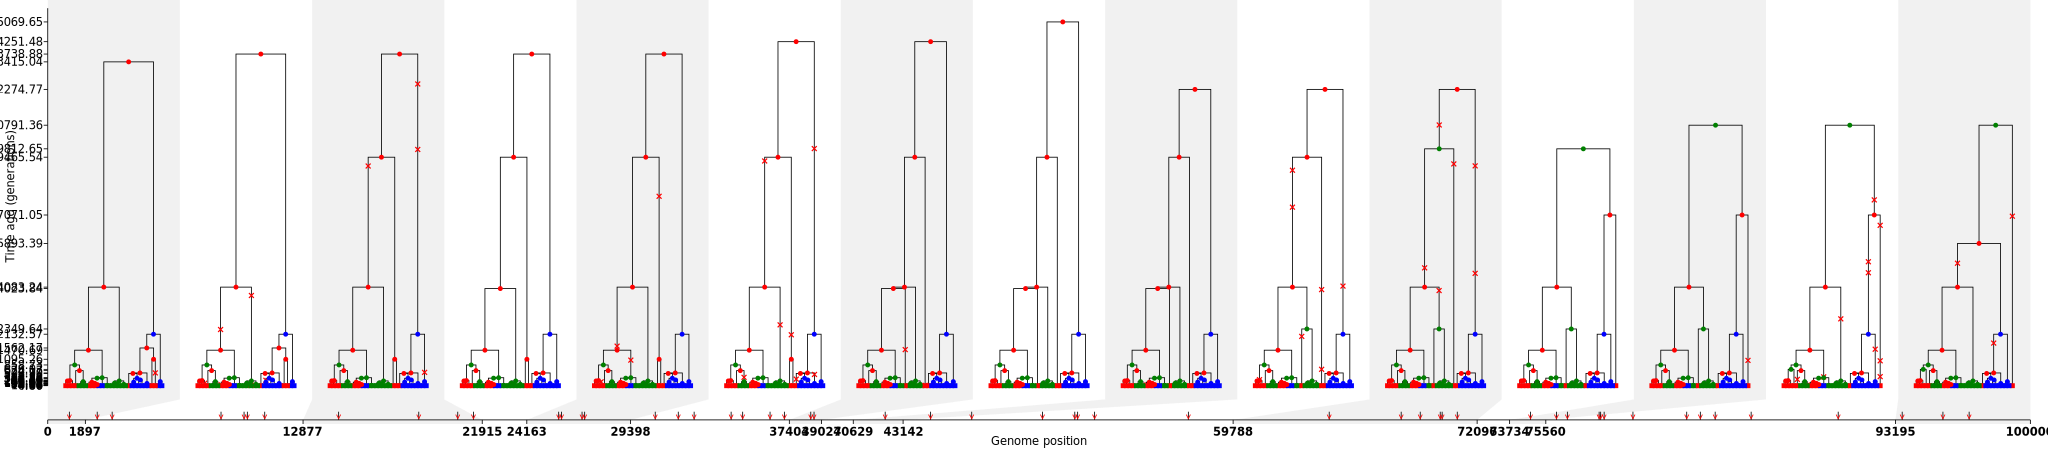

In [13]:
ts_ss.draw_svg(
    size=(2500, 550),
    node_labels={},    # Remove all node labels for a clearer viz
    style=css_ss,  # Apply the stylesheet
    mutation_labels = {},
    y_axis = True
)

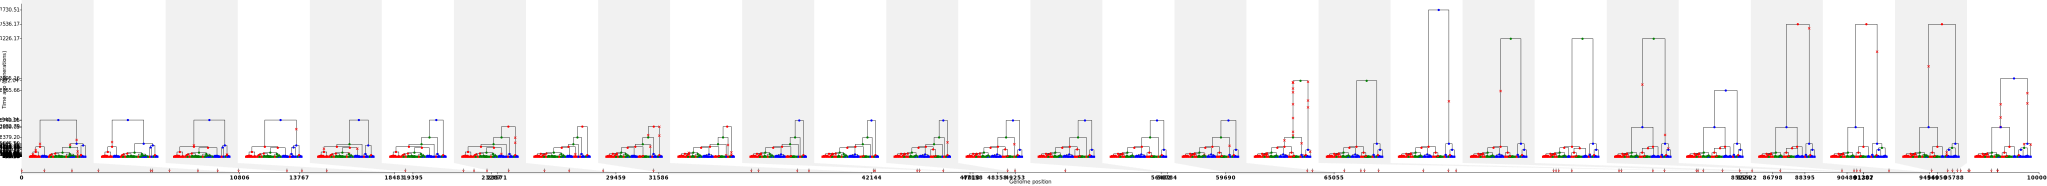

In [14]:
ts_eq.draw_svg(
    size=(5500, 500),
    node_labels={},    # Remove all node labels for a clearer viz
    style=css_eq,  # Apply the stylesheet
    mutation_labels = {},
    y_axis = True
)

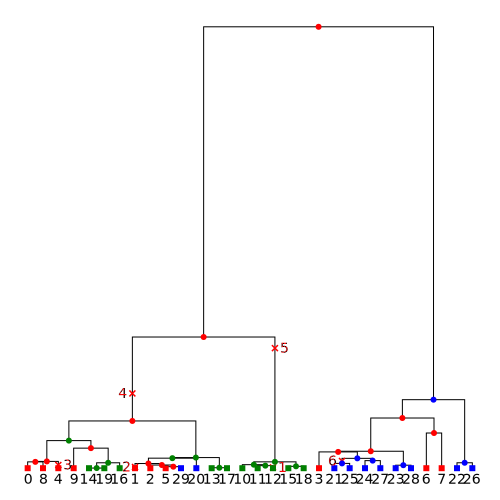

In [15]:
ts_ss.at_index(1).draw_svg(#node_colours=colours_for_node, 
    style=css_ss,
    node_labels=individual_for_node_ss,
    size=(500, 500)
)

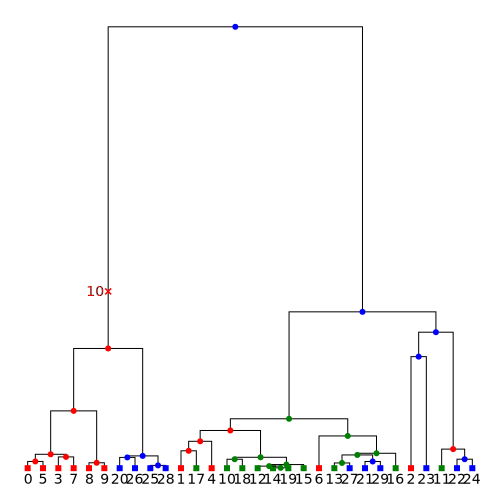

In [16]:
ts_eq.at_index(1).draw_svg(#node_colours=colours_for_node, 
    style=css_eq,
    node_labels=individual_for_node_eq,
    size=(500, 500)
)

In [17]:
# Plot with tips labeled by population

# tip_lab = {u: f"{u}:p{ts.node(u).population}" for u in ts.samples()}
# ts.at_index(1).draw_svg(node_labels=tip_lab, style=css_string, size = (1500,500))

## function for finding location of mrca for every pair of tips in every tree 

In [18]:
def get_locations_df(ts, samples, kind = 'src_snk', trim_flanks = True): 
    type = "inf" 
    if trim_flanks == False:
        type = "sim"
    
    rows = []
    start = 1 if (trim_flanks and ts.num_trees > 2) else 0
    end   = ts.num_trees - 1 if (trim_flanks and ts.num_trees > 2) else ts.num_trees
    for i in range(start, end):
        t = ts.at_index(i)
        L, R = t.interval

        for a, b in combinations(samples, 2):
            u = t.mrca(a, b)
            pop = ts.population(ts.node(u).population).metadata["name"]
            rows.append({
                "index": i, 
                "sample_a": a, 
                "sample_b": b,
                "left": L, 
                "right": R,
                "mrca_population": pop, 
                "type": type,
                "kind": kind,
                "node": u
            })
    return pd.DataFrame(rows)

In [19]:
loc_df_ss = get_locations_df(ts_ss, samples_ss, trim_flanks = False)
loc_df_eq = get_locations_df(ts_eq, samples_eq, kind = 'equal_migration', trim_flanks = False)

loc_df_ss

,index,sample_a,sample_b,left,right,mrca_population,type,kind,node
0,0,0,1,0.0,1897.0,pop_0,sim,src_snk,55
1,0,0,2,0.0,1897.0,pop_0,sim,src_snk,55
2,0,0,3,0.0,1897.0,pop_0,sim,src_snk,67
3,0,0,4,0.0,1897.0,pop_0,sim,src_snk,44
4,0,0,5,0.0,1897.0,pop_0,sim,src_snk,55
...,...,...,...,...,...,...,...,...,...
6520,14,26,28,93195.0,100000.0,pop_2,sim,src_snk,57
6521,14,26,29,93195.0,100000.0,pop_0,sim,src_snk,61
6522,14,27,28,93195.0,100000.0,pop_0,sim,src_snk,50
6523,14,27,29,93195.0,100000.0,pop_0,sim,src_snk,61


## binning 

In [20]:
def make_edges(L, bin_size):
    return np.arange(bin_size/2, int(L) +(bin_size/2), bin_size, dtype=np.int64)
    #return np.arange(0, int(L) + bin_size, bin_size, dtype=np.int64)

def add_bins(df, positions):
    out = []
    
    for i, pos in enumerate(positions):
        mask = (df["left"] <= pos) & (pos < df["right"])   # half-open [left, right) like tskit intervals
        if mask.any():
            tmp = df.loc[mask].copy()
            tmp["bin"] = i
            tmp["position"] = int(pos)
            out.append(tmp)
            
    return pd.concat(out, ignore_index=True)

In [21]:
positions = make_edges(1e5, 1e4)
loc_ss_binned = add_bins(loc_df_ss, positions)
loc_eq_binned = add_bins(loc_df_eq, positions)

loc_ss_binned

,index,sample_a,sample_b,left,right,mrca_population,type,kind,node,bin,position
0,1,0,1,1897.0,12877.0,pop_0,sim,src_snk,55,0,5000
1,1,0,2,1897.0,12877.0,pop_0,sim,src_snk,55,0,5000
2,1,0,3,1897.0,12877.0,pop_0,sim,src_snk,68,0,5000
3,1,0,4,1897.0,12877.0,pop_0,sim,src_snk,44,0,5000
4,1,0,5,1897.0,12877.0,pop_0,sim,src_snk,55,0,5000
...,...,...,...,...,...,...,...,...,...,...,...
4345,14,26,28,93195.0,100000.0,pop_2,sim,src_snk,57,9,95000
4346,14,26,29,93195.0,100000.0,pop_0,sim,src_snk,61,9,95000
4347,14,27,28,93195.0,100000.0,pop_0,sim,src_snk,50,9,95000
4348,14,27,29,93195.0,100000.0,pop_0,sim,src_snk,61,9,95000


In [22]:
#loc_binned.to_csv('locations_df.csv', index=False)

### locations for a given pair aren't consistent! 
i.e. we can see local variation across the tree sequence

In [23]:
counts = pd.DataFrame(loc_df_eq.groupby(['sample_a', 'sample_b', 'mrca_population'])['mrca_population'].count())
counts

mrca_population
sample_a sample_b mrca_population                 
0        1        pop_0                         26
                  pop_2                          2
         2        pop_0                          2
                  pop_1                         19
                  pop_2                          7
...                                            ...
27       29       pop_1                          7
                  pop_2                          8
28       29       pop_0                          7
                  pop_1                          4
                  pop_2                         17

[1063 rows x 1 columns]

In [24]:
# visualize location counts where sample a = 0
counts['mrca_population'][26]

sample_b  mrca_population
27        pop_0              22
          pop_2               6
28        pop_2              28
29        pop_0               7
          pop_1               4
          pop_2              17
Name: mrca_population, dtype: int64

### export trees for gaia 

In [25]:
# 27 01 2026
#ts.dump("demo.trees")

# array([[0.    , 0.    , 0.    ],
#        [0.0003, 0.    , 0.0001],
#        [0.0003, 0.0001, 0.    ]])

In [26]:
# 30 01 2026
# ts.dump("demo.trees")

# array([[0.    , 0.0001, 0.0001],
#        [0.0006, 0.    , 0.0002],
#        [0.0006, 0.0002, 0.    ]])

# infer tree sequence

##### in addition to inferring internal node states directly from msprime output, infer internal node states of inferred tree sequences (i.e. tsinfer+tsdate output) 
    - msprime output 
    - tsinfer output (?)
    - tsinfer+tsdate output (to analyze w/o and w/o inverse-branch-length-weighting?)  

### export/import simulated ts

In [27]:
def fmt_sci(x):
    s = f"{x:.3e}"
    s = s.replace("+0", "+").replace("-0", "-") # reformatting numbers
    return s

def vcf_name(prefix, mu, rr, seed): 
    return f"{prefix}_mu{fmt_sci(mu)}_rr{fmt_sci(rr)}_seed{seed}.vcf"

def vcz_name(prefix, mu, rr, seed):
    return f"{prefix}_mu{fmt_sci(mu)}_rr{fmt_sci(rr)}_seed{seed}.vcz"

# export
# def export_sim(prefix, ts, mu, rr, seed, workdir=".", force=False):
#     os.makedirs(workdir, exist_ok=True)

#     base = os.path.join(workdir, vcz_name(prefix, mu, rr, seed))             # ...vcf.gz.icf.vcz
#     vcf_path   = base.replace(".vcf.gz.icf.vcz", ".vcf")
#     vcfgz_path = base.replace(".icf.vcz", "")                                  # ...vcf.gz
#     icf_path   = base.replace(".vcz", "")                                      # ...vcf.gz.icf

#     # if .vcz exists, skip all
#     if os.path.exists(base):
#         return os.path.abspath(base)

#     # if .icf exists, encode .vcz
#     if os.path.exists(icf_path):
#         cmd = ["vcf2zarr", "encode", icf_path, base]
#         if force: cmd.append("--force")
#         subprocess.run(cmd, check=True)
#         return os.path.abspath(base)

#     # 2) if .vcf.gz, explode -> .icf and encode -> .vcz
#     if os.path.exists(vcfgz_path):
#         cmd = ["vcf2zarr", "explode", vcfgz_path, icf_path]
#         if force: cmd.append("--force")
#         subprocess.run(cmd, check=True)
#         cmd = ["vcf2zarr", "encode", icf_path, base]
#         if force: cmd.append("--force")
#         subprocess.run(cmd, check=True)
#         return os.path.abspath(base)

#     # create .vcf, compress 
#     if not os.path.exists(vcfgz_path):
#         with tempfile.NamedTemporaryFile("w", delete=False, dir=workdir) as tmp:
#             tmp_vcf = tmp.name
#             ts.write_vcf(tmp, position_transform=lambda x: np.fmax(1, x))
#         # compress
#         if shutil.which("bgzip"):
#             subprocess.run(["bgzip", "-f", tmp_vcf], check=True)
#             # bgzip makes tmp_vcf + .gz
#             os.replace(tmp_vcf + ".gz", vcfgz_path)
#         else:
#             with open(tmp_vcf, "rb") as fin, gzip.open(vcfgz_path, "wb") as fout:
#                 fout.write(fin.read())
#             os.remove(tmp_vcf)

#     # explode vcf.gz to icf
#     if not os.path.exists(icf_path):
#         cmd = ["vcf2zarr", "explode", vcfgz_path, icf_path]
#         if force: cmd.append("--force")
#         subprocess.run(cmd, check=True)

#     # encode icf to vzc
#     if not os.path.exists(base):
#         cmd = ["vcf2zarr", "encode", icf_path, base]
#         if force: cmd.append("--force")
#         subprocess.run(cmd, check=True)

#     return os.path.abspath(base)

In [28]:
# with open(f"vcf_stage/{vcf_name('ss', mu, rr, seed)}", "w") as fh: 
#     ts_ss.write_vcf(output = fh)

# with open(f"vcf_stage/{vcf_name('eq', mu, rr, seed)}", "w") as fh: 
#     ts_eq.write_vcf(output = fh)

In [29]:
# def simulate_one(mu, rr, seed, prefix="sim"):
#     dated_ts, samples, ancestral_states = sim(ne, L, rr, mu, seed = seed)  # ground truth TS
#     vcz_path = export_sim(prefix, dated_ts, mu, rr, seed, workdir="vcf_stage")
    
#     return dated_ts, samples, ancestral_states, vcz_path

use bio2zarr to convert VCF into VCZ/: 
```
source ~/tsinfer-env/bin/activate
gzip -k file.vcf
vcf2zarr explode file.vcf.gz file.icf
vcf2zarr encode file.icf file.vcz
```

# run inference

#### import, infer, date

In [30]:
# import vcz -> variant data object
def import_sim(vcz_path, ancestral_states, individuals_time):
    import tsinfer
    vdata = tsinfer.VariantData(
        vcz_path,
        ancestral_state=np.asarray(ancestral_states),
        individuals_time=np.asarray(individuals_time),
    )
    return vdata

In [31]:
# vdata = import_sim(vcz_path, ancestral_states, individuals_time)
vdata_ss = import_sim(f"vcf_stage/{vcz_name('ss', mu, rr, seed)}", ancestral_states_ss, individuals_time_ss)
vdata_eq = import_sim(f"vcf_stage/{vcz_name('eq', mu, rr, seed)}", ancestral_states_eq, individuals_time_eq)

In [32]:
def run_inference(vdata, rr, mu): 
    anc = tsinfer.generate_ancestors(vdata)
    anc_ts = tsinfer.match_ancestors(vdata, anc, recombination_rate = rr, mismatch_ratio = 1.0)
    ts = tsinfer.match_samples(vdata, anc_ts, recombination_rate = rr)
    simplified_ts = tsdate.preprocess_ts(ts, erase_flanks=False)

    dated_ts = tsdate.date(simplified_ts, 
                       mutation_rate=mu, 
                       time_units="generations", 
                       #return_fit=True,
                       match_segregating_sites = True
                       #rescaling_intervals = 492
                       )

    return dated_ts 

In [33]:
dated_ss = run_inference(vdata_ss, rr, mu)
dated_eq = run_inference(vdata_eq, rr, mu)

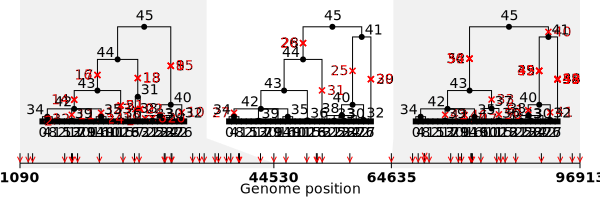

In [34]:
dated_ss.draw_svg()

##### get df, bin etc

In [35]:
def get_locations_inf(ts, samples, kind = 'src_snk', trim_flanks = True): 
    type = "inf" 
    if trim_flanks == False:
        type = "sim"
    
    rows = []
    start = 1 if (trim_flanks and ts.num_trees > 2) else 0
    end   = ts.num_trees - 1 if (trim_flanks and ts.num_trees > 2) else ts.num_trees

    for i in range(start, end):
        t = ts.at_index(i)
        L, R = t.interval
        for a, b in combinations(samples, 2):
            u = t.mrca(a, b)
            pop = 'unlabeled'
            rows.append({
                "index": i, 
                "sample_a": a, 
                "sample_b": b,
                "left": L, 
                "right": R,
                "mrca_population": pop, 
                "type": type,
                "kind": kind,
                "node": u
            })
    return pd.DataFrame(rows)

In [36]:
dated_loc_ss = get_locations_inf(dated_ss, samples_ss, kind = 'src_snk', trim_flanks = True)
dated_los_eq = get_locations_inf(dated_eq, samples_eq, kind = 'equal_migration', trim_flanks = True)

In [37]:
dated_loc_ss_binned = add_bins(dated_loc_ss, positions)
dated_loc_eq_binned = add_bins(dated_los_eq, positions)

In [38]:
#def infer_and_bin(prefix, mu, rr, seed, ancestral_state, samples, individuals_time, kind, trim_flanks = False): 
    # vdata = import_sim(f"vcf_stage/{vcz_name('ss', mu, rr, seed)}", ancestral_states, individuals_time)
    # dated_ts = run_inference(vdata, rr, mu)
    # loc_df_inf = get_locations_df(dated_ts, samples, kind = '', trim_flanks)
    # binned_df = add_bins(loc_df_inf, positions)

    # return binned_df 

## export again

In [39]:
# # ## dfs 

# # loc_ss_binned.to_csv('locations_ss.csv', index=False)
# loc_eq_binned.to_csv('locations_eq.csv', index=False)

dated_loc_ss_binned.to_csv('locations_ss_inf.csv', index=False)
dated_loc_eq_binned.to_csv('locations_eq_inf.csv', index=False)

# # ## tree sequences 

# # ts_ss.dump('ts_ss.trees')
# ts_eq.dump('ts_eq.trees')

# # dated_ss.dump('ts_ss_inf.trees')
# dated_eq.dump('ts_eq_inf.trees')

In [40]:
#### record transition  matrices

#demography.migration_matrix

# future

In [41]:
# insert function for binning tree sequence and re-identifying mrca locations

## validation: proportion of correctly labeled mrca locations 

In [42]:
# insert functions for inferring/dating tree sequence

In [43]:
# insert function for comparing inferred mrca_locations to truth